<a href="https://colab.research.google.com/github/anaC-Fernandes/ProjetoDados/blob/main/Notebooks/Dataset_Crise.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### **Tema:** 📉 Crise
### **Pergunta:** 9. A partir da análise do PIB, quais regiões se recuperaram da recessão de 2014-2016?



## **Manipulação Inicial do dados sobre Crise**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import jinja2

## **Tabela BrStats**

Lendo o arquivo **BrStats** e definindo ';' como separador.

In [2]:
dados = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/BrStats.csv', sep = ';', low_memory= False)
dados

,Ano,CDMunicipio,Populacao,PessoalOcupado,PessoalAssalariado,VrSalarios,PIB,QtEmpresas,AreaPlantada_h,AreaColhida_h,VlProducaoAgricola,VlProducaoPecuaria,Area,Importacoes_US$,Exportacoes_US$,Receitas_R$,Transferencias_correntes_R$,Transferencias_capital_R$,NrNascimentos,NrObitosInfantis,povoamento,UF,Municipio,Regiao
0,2016,3509452,5.932,854,537,13.692,111.190,252.0,38.0,38.0,86.0,1.0,"185,000","40,000",NaN,"25.511.889,220","18.911.068,400","1.665.392,540",80.0,0.0,"32,065",SP,Campina do Monte Alegre,Sudeste
1,2016,3123601,27.505,5.680,4.778,104.977,554.663,671.0,3.0,3.0,649.0,99.0,"499,500","60,000","1.777.256,000","63.002.672,933","45.304.154,440","538.882,600",299.0,3.0,"55,065",MG,Elói Mendes,Sudeste
2,2016,3552007,6.193,668,580,12.519,62.441,83.0,0.0,0.0,3.0,57.0,"414,800","70,000",NaN,"30.492.825,449","21.861.157,950","1.048.458,040",59.0,2.0,"14,930",SP,Silveiras,Sudeste
3,2016,3305604,21.279,3.087,2.669,80.161,403.121,290.0,0.0,0.0,4.0,7.0,"937,500","97,000",NaN,"140.538.926,872","100.508.822,360","871.234,340",272.0,2.0,"22,698",RJ,Silva Jardim,Sudeste
4,2016,1717008,4.534,212,183,5.309,48.551,34.0,94.0,34.0,0.0,4.0,"1.559,100","107,000",NaN,"15.541.375,953","13.178.989,760","8.037,870",43.0,1.0,"2,908",TO,Pindorama do Tocantins,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33415,2021,2705408,7.171,463,436,10.502,NaN,32.0,0.0,0.0,0.0,7.0,"86,100",NaN,NaN,NaN,NaN,NaN,135.0,3.0,"83,287",AL,Monteirópolis,Nordeste
33416,2021,1600105,9.265,428,383,9.932,NaN,38.0,0.0,0.0,4.0,0.0,"9.175,900",NaN,NaN,NaN,NaN,NaN,160.0,2.0,"1,010",AP,Amapá,Norte
33417,2019,2605459,3.061,2.210,1.773,43.093,192.775,289.0,0.0,0.0,0.0,32.0,"17,000",NaN,NaN,NaN,NaN,NaN,32.0,1.0,"180,059",PE,Fernando de Noronha,Nordeste
33418,2020,1503002,7.070,538,514,12.207,63.579,32.0,0.0,0.0,6.0,0.0,"11.770,600",NaN,NaN,NaN,NaN,NaN,149.0,4.0,"0,601",PA,Faro,Norte


### Tabela BrStats contendo apenas 'UF', 'Municipio', 'Regiao'e 'PIB'

Para responder a pergunta **9. A partir da análise do PIB, quais municípios se recuperaram da recessão de 2014-2016?** precisaremos apenas dos seguintes dados:
- UF
- Municipio
- Regiao
- PIB
- Ano

Por esse motivo fizemos uma filtragem na tabela BrStats, retirando os dados não necessãrios para essa pergunta.

In [3]:
dados_filtrados = dados[['UF', 'Municipio', 'Regiao', 'PIB', 'Ano']]

dados_filtrados

,UF,Municipio,Regiao,PIB,Ano
0,SP,Campina do Monte Alegre,Sudeste,111.190,2016
1,MG,Elói Mendes,Sudeste,554.663,2016
2,SP,Silveiras,Sudeste,62.441,2016
3,RJ,Silva Jardim,Sudeste,403.121,2016
4,TO,Pindorama do Tocantins,Norte,48.551,2016
...,...,...,...,...,...
33415,AL,Monteirópolis,Nordeste,NaN,2021
33416,AP,Amapá,Norte,NaN,2021
33417,PE,Fernando de Noronha,Nordeste,192.775,2019
33418,PA,Faro,Norte,63.579,2020


É possível salvar a nova tabela em um arquivo .csv separado:

In [4]:
dados_filtrados.to_csv("BrStats_crise.csv", index=False)

## **Tabela sidra**

Como mencionado no README, fizemos uma busca no Sidra para encontrar dados do PIB dos municípios brasileiros dos anos de 2013 (anterior a crise) até 2016 (fim da crise), o arquivo gerado é o sidra.csv.

Abaixo estamos carregando e manipulando o arquivo sidra, para que possamos unir as duas tabelas de dados.

In [5]:
# Carregando o arquivo CSV com a codificação correta UTF-8, pois estava perdendo acentos
dados_sidra = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/sidra.csv', skiprows=1, encoding='utf-8')

# Renomeando as colunas
dados_sidra.columns = ['Município', '2013', '2014', '2015', '2016', '2017']

# Removendo linhas sem dados úteis que vieram do PDF (Fonte, Notas, etc.)
dados_sidra = dados_sidra.dropna() 
dados_sidra = dados_sidra[~dados_sidra['Município'].str.contains('Fonte:|Notas|1 -', na=False)] 

# Salvando o arquivo corrigido com codificação UTF-8
dados_sidra.to_csv('sidra_limpos.csv', index=False, encoding='utf-8-sig')

Um detalhe a ser corrigido antes de unirmos as tabelas do BrStats com a do Sidra é a maneira como municípios e UF estão registrados, enquanto o dataset BrStats possui uma coluna chamada 'UF', o dataset do Sidra escreve a UF na mesma coluna do município, e por isso devemos criar uma nova coluna nesse dataset.

In [6]:
# Criando a coluna UF
if 'UF' not in dados_sidra.columns:
    dados_sidra['UF'] = ''

# Separaando Município e UF
dados_sidra[['Município', 'UF']] = dados_sidra['Município'].str.extract(r'(.+) \((\w{2})\)')

dados_sidra

,Município,2013,2014,2015,2016,2017,UF
0,Alta Floresta D'Oeste,341.325,377.799,421.300,478.217,485.374,RO
1,Ariquemes,1.799.853,1.921.532,2.037.799,2.184.346,2.287.910,RO
2,Cabixi,96.365,113.477,116.565,133.342,138.110,RO
3,Cacoal,1.433.254,1.660.650,1.794.478,1.947.283,2.082.761,RO
4,Cerejeiras,353.270,392.417,397.736,408.194,439.245,RO
...,...,...,...,...,...,...,...
5565,Vianópolis,291.919,302.880,312.348,373.802,395.861,GO
5566,Vicentinópolis,259.422,275.800,322.298,351.750,350.839,GO
5567,Vila Boa,103.233,90.478,111.229,138.810,118.639,GO
5568,Vila Propício,142.970,138.474,198.935,210.475,182.203,GO


## **Unindo os dois Datasets**

O dataset BrStats não possui colunas específicas para os anos em que os PIBs foram registrados, então optamos por fazer divisão para facilitar a análise.

In [7]:
# Criando um DataFrame onde cada ano vira uma coluna
dados = dados.pivot_table(
    index=['UF', 'Municipio', 'Regiao'],  # Colunas que permanecerão como índice
    columns='Ano',                        # Coluna que será transformada em novas colunas
    values='PIB',                         # Valores que preencherão as novas colunas
    aggfunc='first'                       # Função de agregação (usamos 'first' pois não há duplicatas)
)

# Resetar o índice para trazer UF, Municipio e Regiao de volta como colunas
dados = dados.reset_index()

dados

Ano,UF,Municipio,Regiao,2016,2017,2018,2019,2020
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318
...,...,...,...,...,...,...,...,...
5560,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159
5561,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549
5562,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798
5563,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907


Outro problema a ser corrigido é a coluna 'Municipio' no dataset do Sidra, que possui acentuação, enquanto a do BrStats não possui, e precisaremos que elas possuam nomeclatura idêntica para uni-las.

In [8]:
dados_sidra = dados_sidra.rename(columns={'Município': 'Municipio'})

Unindo os dois datasets utilizando como base as colunas 'Municipio' e 'UF'.

In [9]:
dados_crise = dados.merge(dados_sidra, on=['Municipio', 'UF'])

# Salvar o arquivo corrigido com codificação UTF-8
dados_crise.to_csv('dados_crise.csv', index=False, encoding='utf-8-sig')

dados_crise

,UF,Municipio,Regiao,2016,2017,2018,2019,2020,2013,2014,2015,2016,2017
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445,214.652,207.822,212.961,239.610,229.644
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920,64.602,73.332,77.234,85.322,91.743
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142,294.874,340.917,388.114,388.521,388.018
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818,120.210,129.895,147.868,159.696,158.301
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318,158.800,149.067,160.134,177.480,170.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159,47.927,49.172,58.998,61.070,67.831
5445,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549,79.472,68.282,47.485,46.019,46.142
5446,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798,21.891,25.998,24.533,28.051,28.582
5447,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907,125.772,134.428,138.573,154.098,161.897


É possível perceber que o dataset ainda precisa de alguns ajustes, como ordenar corretamente os anos e remover os que se repetem.

In [10]:
dados_crise = pd.read_csv('dados_crise.csv')
dados_crise

,UF,Municipio,Regiao,2016,2017,2018,2019,2020,2013,2014,2015,2016.1,2017.1
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445,214.652,207.822,212.961,239.610,229.644
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920,64.602,73.332,77.234,85.322,91.743
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142,294.874,340.917,388.114,388.521,388.018
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818,120.210,129.895,147.868,159.696,158.301
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318,158.800,149.067,160.134,177.480,170.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159,47.927,49.172,58.998,61.070,67.831
5445,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549,79.472,68.282,47.485,46.019,46.142
5446,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798,21.891,25.998,24.533,28.051,28.582
5447,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907,125.772,134.428,138.573,154.098,161.897


In [11]:
# Removendo colunas duplicadas
cols_to_remove = ['2016.1', '2017.1']
dados_crise = dados_crise.drop(columns=[col for col in cols_to_remove if col in dados_crise.columns])

# Reordenando colunas
fixed_cols = ['UF', 'Municipio', 'Regiao']
year_cols = sorted([col for col in dados_crise.columns if col.isdigit()])
dados_crise = dados_crise[fixed_cols + year_cols]

# Salvando o resultado
output_file = '.dados_final.csv'
dados_crise.to_csv(output_file, index=False)

dados_crise

,UF,Municipio,Regiao,2013,2014,2015,2016,2017,2018,2019,2020
0,AC,Acrelândia,Norte,214.652,207.822,212.961,239.610,229.644,253.138,253.152,302.445
1,AC,Assis Brasil,Norte,64.602,73.332,77.234,85.322,91.743,89.875,92.705,96.920
2,AC,Brasiléia,Norte,294.874,340.917,388.114,388.521,388.018,439.547,454.009,480.142
3,AC,Bujari,Norte,120.210,129.895,147.868,159.696,158.301,158.191,159.100,183.818
4,AC,Capixaba,Norte,158.800,149.067,160.134,177.480,170.990,164.238,152.806,145.318
...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,47.927,49.172,58.998,61.070,67.831,71.807,129.131,135.159
5445,TO,Tupirama,Norte,79.472,68.282,47.485,46.019,46.142,49.166,55.980,94.549
5446,TO,Tupiratins,Norte,21.891,25.998,24.533,28.051,28.582,29.772,29.993,33.798
5447,TO,Wanderlândia,Norte,125.772,134.428,138.573,154.098,161.897,140.641,134.885,149.907


Com isso obtivemos um dataset com apenas os dados necessários para a análise do PIB antes, durante e depois da crise de 2014-2016.

## **Conversão dos dados para os tipos corretos**

In [12]:
for col in year_cols:
    dados_crise[col] = (
        dados_crise[col]
        .str.replace('.', '', regex=False)  
        .str.replace(',', '.', regex=False)  
        .astype(float)  
    )

dados_crise[['UF', 'Municipio', 'Regiao']] = dados_crise[['UF', 'Municipio', 'Regiao']].astype('string')

dados_crise.dtypes

UF           string[python]
Municipio    string[python]
Regiao       string[python]
2013                float64
2014                float64
2015                float64
2016                float64
2017                float64
2018                float64
2019                float64
2020                float64
dtype: object

## **Verificações para a criação da visualização**

Agrupando os valores do PIB de cada ano por Região.

In [13]:
pib_por_regiao = dados_crise.groupby('Regiao')[year_cols].sum().reset_index()
pib_por_regiao


,Regiao,2013,2014,2015,2016,2017,2018,2019,2020
0,Centro-Oeste,4.821953e+08,5.387389e+08,5.755057e+08,6.283954e+08,6.549790e+08,6.895188e+08,7.258046e+08,7.844388e+08
1,Nordeste,7.176832e+08,7.975530e+08,8.408190e+08,8.903064e+08,9.451371e+08,9.967322e+08,1.039234e+09,1.070712e+09
2,Norte,2.890180e+08,3.044349e+08,3.168797e+08,3.331675e+08,3.634310e+08,3.827987e+08,4.155338e+08,4.726262e+08
3,Sudeste,2.914142e+09,3.136885e+09,3.200516e+09,3.294500e+09,3.440025e+09,3.675905e+09,3.868775e+09,3.904106e+09
4,Sul,8.754501e+08,9.430825e+08,1.002035e+09,1.060438e+09,1.114446e+09,1.187415e+09,1.263803e+09,1.299476e+09


Criando a coluna de PIB total por região.

In [14]:
pib_por_regiao = dados_crise.groupby('Regiao')[year_cols].sum()
pib_por_regiao['Total'] = pib_por_regiao.sum(axis=1)
pib_por_regiao = pib_por_regiao.reset_index()

pib_por_regiao

,Regiao,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Centro-Oeste,4.821953e+08,5.387389e+08,5.755057e+08,6.283954e+08,6.549790e+08,6.895188e+08,7.258046e+08,7.844388e+08,5.079577e+09
1,Nordeste,7.176832e+08,7.975530e+08,8.408190e+08,8.903064e+08,9.451371e+08,9.967322e+08,1.039234e+09,1.070712e+09,7.298177e+09
2,Norte,2.890180e+08,3.044349e+08,3.168797e+08,3.331675e+08,3.634310e+08,3.827987e+08,4.155338e+08,4.726262e+08,2.877890e+09
3,Sudeste,2.914142e+09,3.136885e+09,3.200516e+09,3.294500e+09,3.440025e+09,3.675905e+09,3.868775e+09,3.904106e+09,2.743485e+10
4,Sul,8.754501e+08,9.430825e+08,1.002035e+09,1.060438e+09,1.114446e+09,1.187415e+09,1.263803e+09,1.299476e+09,8.746145e+09


Alterando os valores para serem mostrados em bilhões de reais.

In [15]:
for col in year_cols:
    pib_por_regiao[col] = (pib_por_regiao[col] / 1e9).round(2)

pib_por_regiao['Total'] = (pib_por_regiao['Total'] / 1e9).round(2)

pib_por_regiao

,Regiao,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Centro-Oeste,0.48,0.54,0.58,0.63,0.65,0.69,0.73,0.78,5.08
1,Nordeste,0.72,0.80,0.84,0.89,0.95,1.00,1.04,1.07,7.30
2,Norte,0.29,0.30,0.32,0.33,0.36,0.38,0.42,0.47,2.88
3,Sudeste,2.91,3.14,3.20,3.29,3.44,3.68,3.87,3.90,27.43
4,Sul,0.88,0.94,1.00,1.06,1.11,1.19,1.26,1.30,8.75


In [16]:
pib_por_regiao.set_index('Regiao', inplace=True)
pib_por_regiao

,2013,2014,2015,2016,2017,2018,2019,2020,Total
Regiao,,,,,,,,,
Centro-Oeste,0.48,0.54,0.58,0.63,0.65,0.69,0.73,0.78,5.08
Nordeste,0.72,0.80,0.84,0.89,0.95,1.00,1.04,1.07,7.30
Norte,0.29,0.30,0.32,0.33,0.36,0.38,0.42,0.47,2.88
Sudeste,2.91,3.14,3.20,3.29,3.44,3.68,3.87,3.90,27.43
Sul,0.88,0.94,1.00,1.06,1.11,1.19,1.26,1.30,8.75


## **Gráficos do PIB por Região**

### **Correção do PIB Nominal para PIB Real**

In [17]:
# Remover a coluna 'Total' para focar nos anos
dados_grafico = pib_por_regiao.drop(columns=['Total'])

Inicialmente é importante visualizar como o valor do PIB total de cada região se comportou ao longo dos anos (2013-2020), para isso foi feito um gráfico de linhas que mostra os valores do PIB em cada ano em bilhões por região.

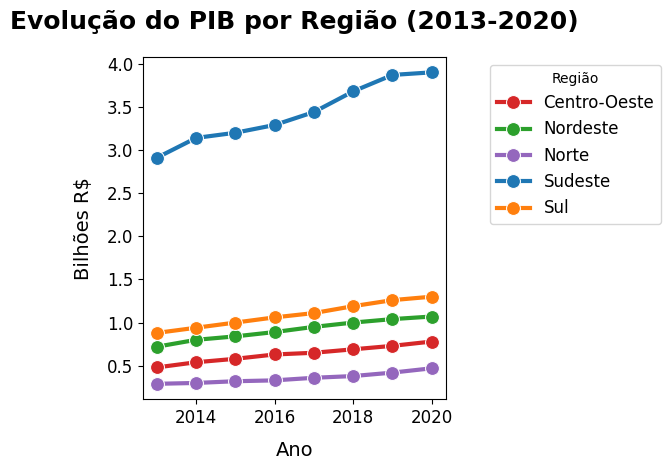

In [18]:
# Preparar os dados 
dados_long = dados_grafico.reset_index().melt(id_vars='Regiao', var_name='Ano', value_name='PIB')
dados_long['Ano'] = pd.to_numeric(dados_long['Ano'])

# Criar o gráfico com Seaborn
ax = sns.lineplot(data=dados_long, 
                 x='Ano', 
                 y='PIB', 
                 hue='Regiao',
                 marker='o',
                 markersize=10,
                 linewidth=3,
                 palette={
                     'Sudeste': '#1f77b4',
                     'Sul': '#ff7f0e',
                     'Nordeste': '#2ca02c',
                     'Centro-Oeste': '#d62728',
                     'Norte': '#9467bd'
                 })

# Formatação 
plt.title('Evolução do PIB por Região (2013-2020)', fontsize=18, pad=20, weight='bold')
plt.xlabel('Ano', fontsize=14, labelpad=10)
plt.ylabel('Bilhões R$', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Região', bbox_to_anchor=(1.12, 1), fontsize=12)

plt.tight_layout()
plt.show()

Foi feito também um heatmap, para que seja mais fácil de visualizar a diferença entre o PIB Nominal e o PIB Real.

<Axes: ylabel='Regiao'>

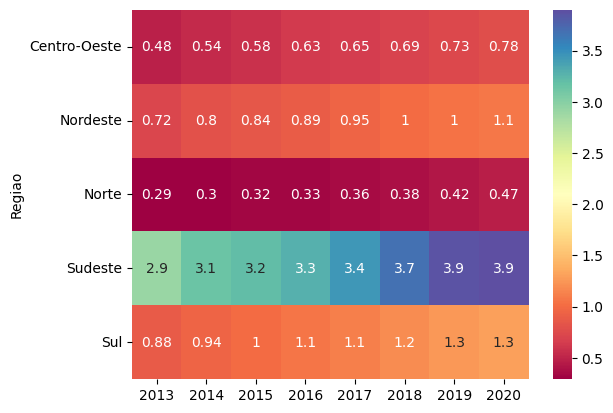

In [19]:
sns.heatmap(dados_grafico, cmap="Spectral", annot=True)

Observando os gráficos acima possível perceber a discrepância entre os PIBs de outras regiões em relação ao Sudeste, isso ocorre por diversos fatores, entre eles fatores históricos, econômicos, geográficos e estruturais. O Sudeste é composto pelos estados Espírito Santo (ES), Minas Gerais (MG), São Paulo (SP) e Rio de Janeiro (RJ), e é a região com a maior população do Brasil o que estimula a economia, sendo também históricamente o centro da economia brasileira desde o ciclo do café. 

Então é natural que o PIB dessa região seja tão elevado se comparado as demais, apesar do Sul ter uma economia forte, ele possui uma menor escala populacional e industrial, enquanto o Nordeste ainda sofre com infraestrutura limitada e menor industrialização, e o Norte e Centro-Oeste baseiam-se mais em agropecuária e mineração.

Além disso, é perceptível que o PIB ao longos do anos **cresce**, o que contradiz as nossas afimações iniciais de que o PIB sofreu uma grande queda durante a crise de 2014-2016. 

Após uma análise dos motivos por trás dessa contradição, percebemos que o PIB que estamos utilizando nesse projeto (tanto do BrStats quando da tabela do Sidra) é o PIB Nominal, que não é ajustado com base da inflação. Para uma análise real da queda do PIB durante esses anos precisamos do PIB Real, que pode ser obtido utilizando o IPCA (Índice Nacional de Preços ao Consumidor Amplo) fornecido pelo IBGE. 

Para fazermos a conversão do PIB Nominal para o PIB Real, retiramos o IPCA anual do site da [SEAD](https://sead.ac.gov.br/tabela-85-principais-indicadores-inflacionarios-do-brasil/?utm_source=chatgpt.com) (Secretaria de Estado de Administração).

In [20]:
ipca = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/ipca_2013_2020.csv', sep = ',', low_memory= False)

ipca[['Ano']].astype('int')
ipca[['IPCA (%)']].astype('float')

ipca

,Ano,IPCA (%)
0,2013,5.91
1,2014,6.41
2,2015,10.67
3,2016,6.29
4,2017,2.95
5,2018,3.75
6,2019,4.31
7,2020,4.52


A partir do IPCA podemos fazer uma conversão do PIB Nominal para o PIB Real, seguindo o [Manual de Contas Nacionais do IBGE](https://ftp.ibge.gov.br/Contas_Nacionais/Sistema_de_Contas_Nacionais/Notas_Metodologicas_2010/02_estrutura_scn.pdf) (2010), podemos obter o PIB Real pela deflação do PIB Nominal utilizando um índice de preços apropriado, como o IPCA, dividindo o valor do PIB Nominal pelo índice de preços ajustado para o ano-base, removendo o efeito da inflação. 

Essa prática metodológica também é reforçada na literatura econômica, como em Blanchard (2017), que descreve o uso de índices de preços para converter valores nominais em valores reais, permitindo comparações ao longo do tempo.

Utilizaremos a seguinte fórmula para a conversão: 

$PIB \quad REAL = \frac{PIB \quad NOMINAL}{IPCA}$

In [21]:
# Copiando pib_por_regiao para pib_real
pib_real = pib_por_regiao.copy()

# Calcular PIB real em todas as colunas de ano
for year in year_cols:
    pib_real[year] = pib_por_regiao[year] / ipca.loc[ipca['Ano'] == int(year), 'IPCA (%)'].values[0]

# Remover a coluna 'Total'
pib_real = pib_real.drop(columns=['Total'])

# Exibir o resultado
pib_real

,2013,2014,2015,2016,2017,2018,2019,2020
Regiao,,,,,,,,
Centro-Oeste,0.081218,0.084243,0.054358,0.100159,0.220339,0.184000,0.169374,0.172566
Nordeste,0.121827,0.124805,0.078725,0.141494,0.322034,0.266667,0.241299,0.236726
Norte,0.049069,0.046802,0.029991,0.052464,0.122034,0.101333,0.097448,0.103982
Sudeste,0.492386,0.489860,0.299906,0.523052,1.166102,0.981333,0.897912,0.862832
Sul,0.148900,0.146646,0.093721,0.168521,0.376271,0.317333,0.292343,0.287611


### **Visualização do PIB Real**

Agora que temos o PIB Real de cada ano, podemos visualizar o gráfico correspondente aos valores corrigidos.

Os valores nos pontos estavam se sobrepondo, e por esse motivo foram retirados, o mais importante é ser possível perceber como há uma queda do PIB Real entre 2014-2016 em todas as regiões.

<Figure size 2000x1000 with 0 Axes>

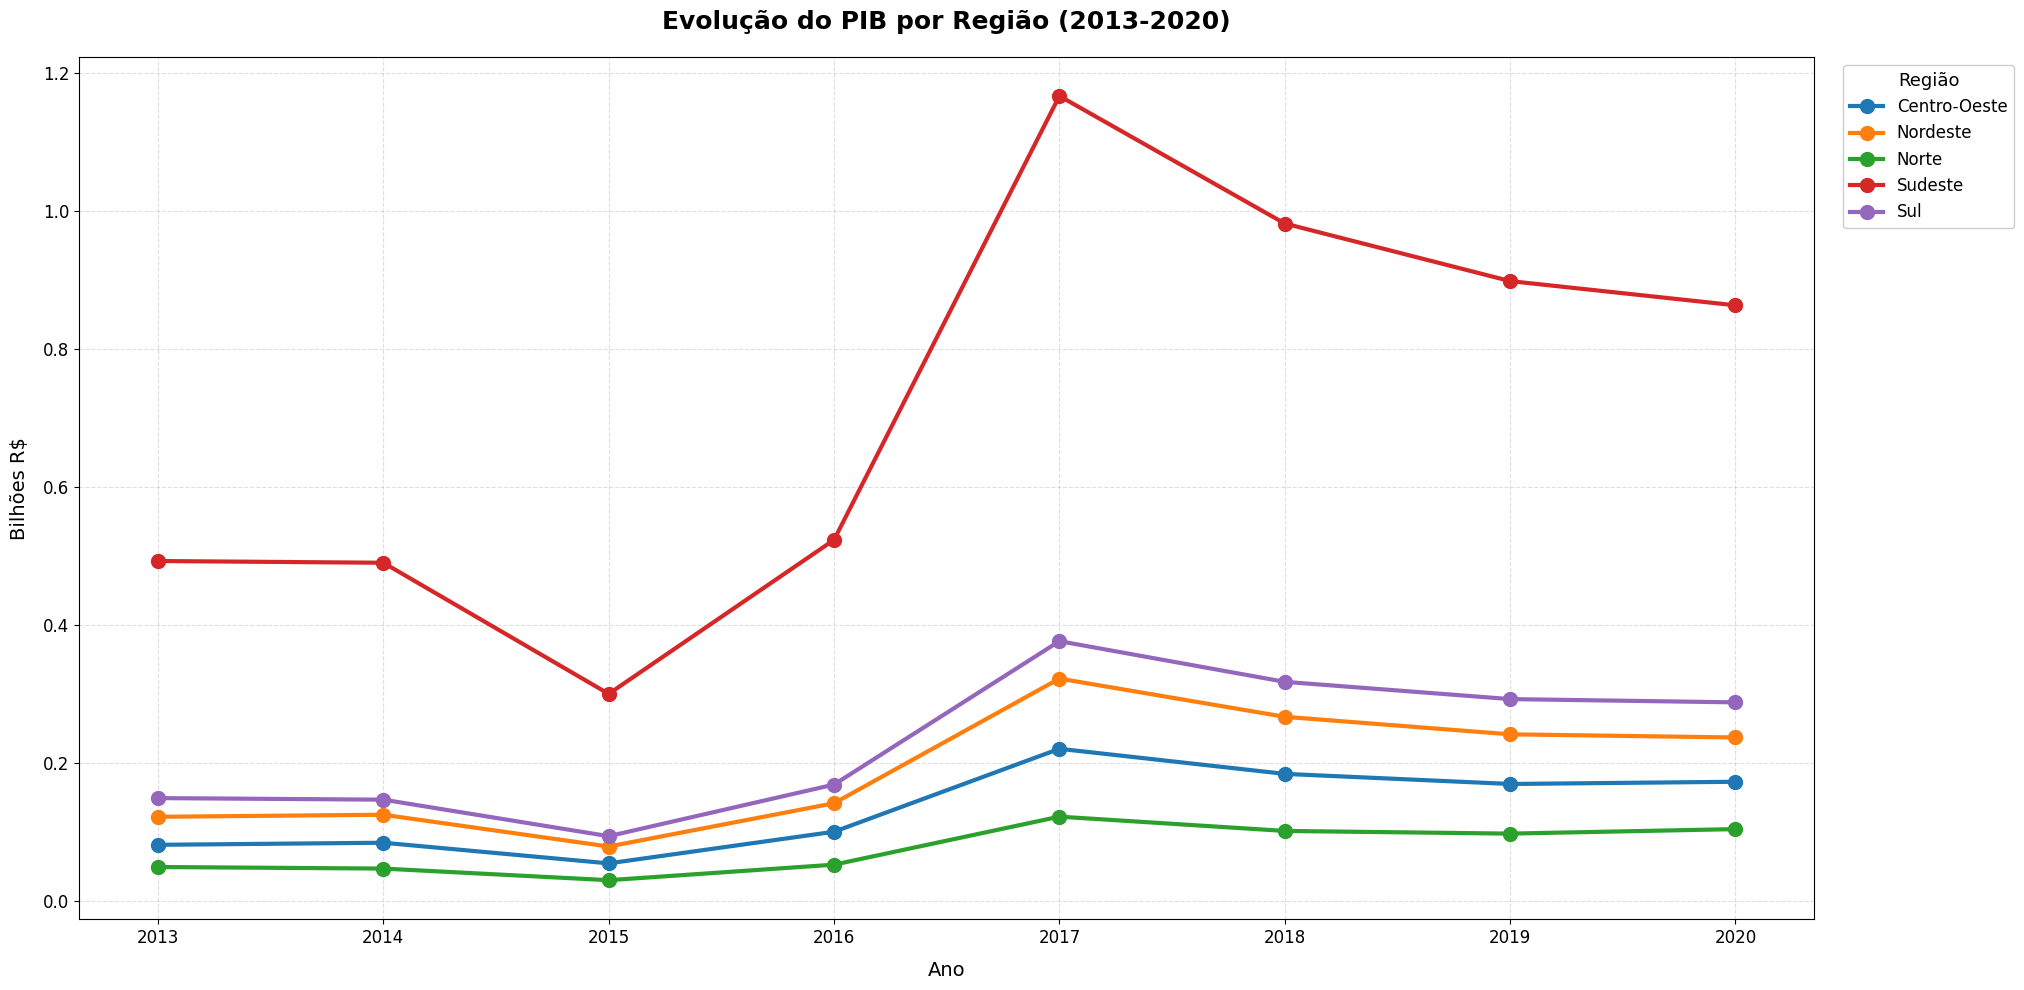

In [22]:
# Tamanho e resolução da figura
plt.figure(figsize=(20, 10), dpi=100)  

# Transpor e converter os dados
dados_transpostos = pib_real.T
dados_transpostos.index = pd.to_numeric(dados_transpostos.index)

# Plot
ax = dados_transpostos.plot(kind='line',
                          marker='o',
                          markersize=10,  # Marcadores maiores
                          linewidth=3,    # Linhas mais grossas
                          figsize=(20, 10))

# Formatação 
plt.title('Evolução do PIB por Região (2013-2020)', 
         fontsize=18, pad=20, weight='bold')
plt.xlabel('Ano', fontsize=14, labelpad=10)
plt.ylabel('Bilhões R$', fontsize=14, labelpad=10)
plt.grid(alpha=0.4, linestyle='--')

# Ajustar eixos
plt.xticks(dados_transpostos.index, fontsize=12) 
plt.yticks(fontsize=12)

# Legenda
plt.legend(title='Região',
          bbox_to_anchor=(1.12, 1),
          fontsize=12,
          title_fontsize=13,
          framealpha=1)

# Ajustar margens
plt.subplots_adjust(right=0.85)  # Espaço para a legenda
plt.tight_layout()
plt.show()

No heatmap abaixo é interessante perceber que em todas regiões a coluna mais escura é do ano de 2015, onde o PIB Real é muito menor se comparado aos seus vizinhos. E é interessante perceber também com a escala de cores na região Sudeste conta com cores não vistas em nenhuma outra região, pelo motivos que citamos anteriormente.

<Axes: ylabel='Regiao'>

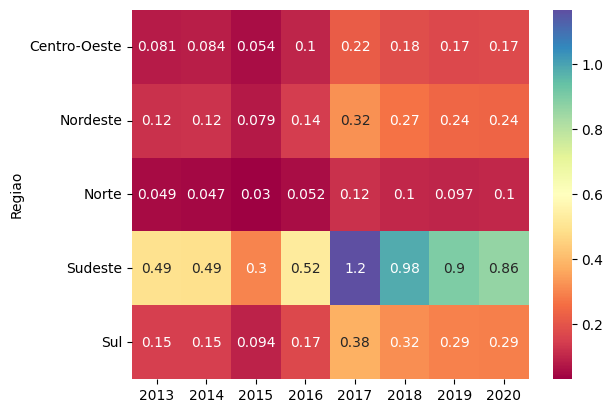

In [23]:
sns.heatmap(pib_real, cmap="Spectral", annot=True)

### **Conclusão**

A partir da análise do PIB Real podemos confirmar que realmente houve uma queda entre os anos de 2014 e 2016, e que o ano de 2015 foi onde ouve o menor valor do PIB para todas as regiões do país. Mas já np ano de 2017 o PIB Real volta a subir, atingindo valores até mesmo maiores do que os vistos antes da crise, então podemos afirmar que ,a partir da análise do PIB Real, as regiões do Brasil foram capazes de se recuperarem da crise de 2014-2016.

# **Gráficos do PIB por Município**

Por serem muitos municípios faremos uma divisão por região, e faremos uma comparação do PIB desse municípios em 2013 (antes da crise) e no ano após a crise (2017).

In [24]:
# Dicionário para as tabelas
municipios_por_regiao = {}

# Pegar todas as regiões únicas
regioes = dados_crise['Regiao'].unique()

for regiao in regioes:
    municipios_por_regiao[regiao] = dados_crise[dados_crise['Regiao'] == regiao]

for regiao in regioes:
    tabela = dados_crise[dados_crise['Regiao'] == regiao].copy()
    tabela[year_cols] = (tabela[year_cols] / 1_000_000).round(2)  # Converte para milhões e arredonda
    municipios_por_regiao[regiao] = tabela


Abaixo estamos apenas listando quantos municípios de cada região foram capazes de se recuperar.

In [25]:
municipios_recuperados_por_regiao = {}

ano_referencia = '2013'
ano_verificacao = '2017'  

for regiao, df_regiao in municipios_por_regiao.items():
    municipios_recuperados = []

    for idx, row in df_regiao.iterrows():
        pib_2013 = row[ano_referencia]

        # Verificar se o PIB de 2017 foi >= PIB de 2013
        recuperou = row[ano_verificacao] >= pib_2013

        if recuperou:
            municipios_recuperados.append(row['Municipio'])

    municipios_recuperados_por_regiao[regiao] = municipios_recuperados

# Exibir a quantidade de municípios recuperados por região em relação ao total
for regiao, municipios in municipios_recuperados_por_regiao.items():
    total_municipios = len(municipios_por_regiao[regiao])
    recuperados = len(municipios)
    print(f"Região {regiao}: {recuperados} de {total_municipios} municípios se recuperaram da crise")

Região Norte: 419 de 434 municípios se recuperaram da crise
Região Nordeste: 1703 de 1756 municípios se recuperaram da crise
Região Centro-Oeste: 436 de 450 municípios se recuperaram da crise
Região Sudeste: 1542 de 1641 municípios se recuperaram da crise
Região Sul: 1105 de 1168 municípios se recuperaram da crise


 Ao tentar fazer um gráfico de barras para a porcentagem de recuperação em cada região podemos perceber que em todos o casos mais de 94% dos municípios se recuperaram, por esse motivo optamos por mostrar graficamente os municípios que atingiram o maior PIB Real logo após o fim da crise, e os municípios que mostraram o menor PIB Real se comparado ao ano antes da crise.

In [26]:
comparacao_pib = []

for regiao, df_regiao in municipios_por_regiao.items():
    for idx, row in df_regiao.iterrows():
        pib_2013 = row['2013']
        pib_2017 = row['2017']

        # Diferença entre 2017 e 2013
        diferenca = pib_2017 - pib_2013

        # PIB_2017 >= PIB_2013
        recuperou = 'Recuperado' if pib_2017 >= pib_2013 else 'Não Recuperado'

        comparacao_pib.append({
            'Municipio': row['Municipio'],
            'Regiao': regiao,
            'Diferenca PIB (2017 - 2013)': diferenca,
            'Status Recuperacao': recuperou
        })

df_comparacao = pd.DataFrame(comparacao_pib)


O gráfico da esquerda mostra os municípios com maior recuperação, enquanto o gráfico da direita mostra os que não se recuperaram com uma distância maior do PIB Real anterior a crise.

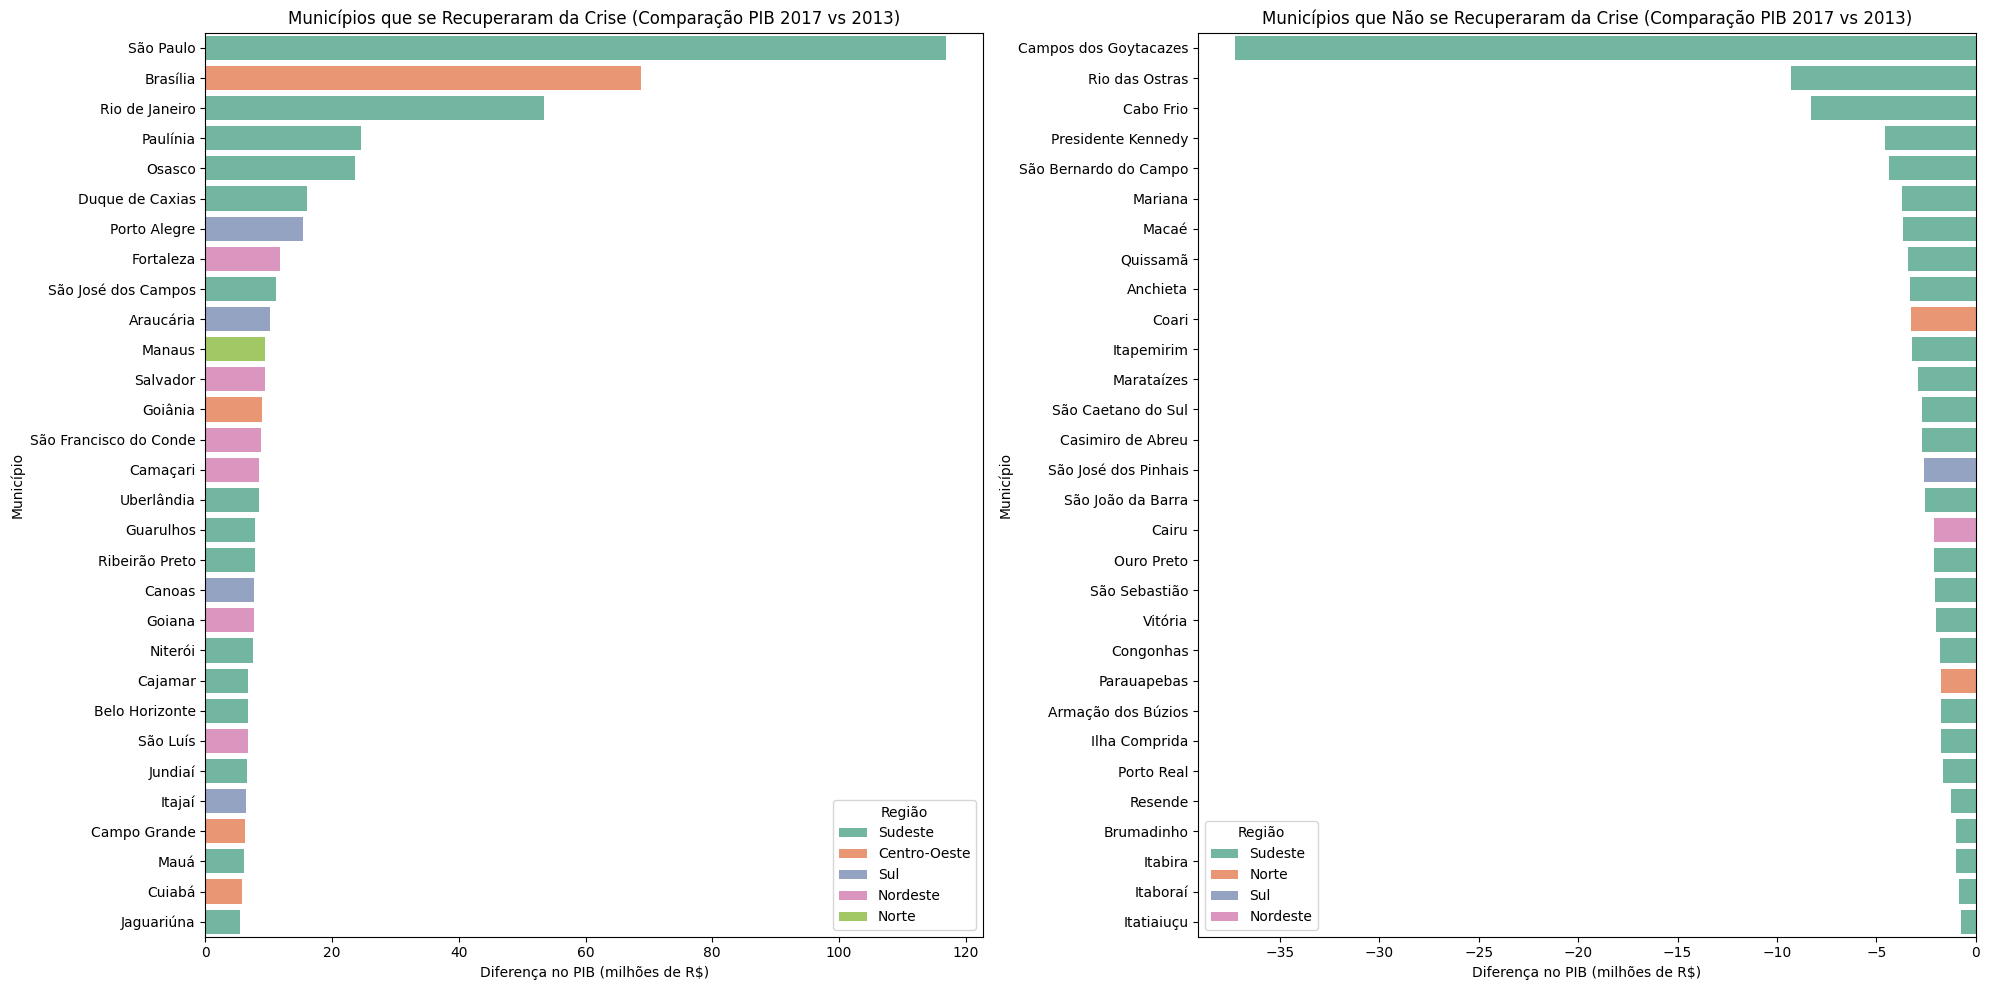

In [27]:
# Dois gráficos lado a lado com o subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico 1 - Municípios Recuperados
dados_plot_recuperados = df_comparacao[df_comparacao['Status Recuperacao'] == 'Recuperado'].copy()
dados_plot_recuperados = dados_plot_recuperados.sort_values('Diferenca PIB (2017 - 2013)', ascending=False).head(30)

sns.barplot(
    data=dados_plot_recuperados,
    y='Municipio',
    x='Diferenca PIB (2017 - 2013)',
    hue='Regiao',
    dodge=False,
    palette='Set2',
    ax=axes[0]  # Definir o gráfico no eixo 0
)

axes[0].set_title('Municípios que se Recuperaram da Crise (Comparação PIB 2017 vs 2013)')
axes[0].set_xlabel('Diferença no PIB (milhões de R$)')
axes[0].set_ylabel('Município')
axes[0].legend(title='Região')

# Gráfico 2 - Municípios Não Recuperados
dados_plot_nao_recuperados = df_comparacao[df_comparacao['Status Recuperacao'] == 'Não Recuperado'].copy()
dados_plot_nao_recuperados = dados_plot_nao_recuperados.sort_values('Diferenca PIB (2017 - 2013)', ascending=True).head(30)

sns.barplot(
    data=dados_plot_nao_recuperados,
    y='Municipio',
    x='Diferenca PIB (2017 - 2013)',
    hue='Regiao',
    dodge=False,
    palette='Set2',
    ax=axes[1]  # Definir o gráfico no eixo 1
)

axes[1].set_title('Municípios que Não se Recuperaram da Crise (Comparação PIB 2017 vs 2013)')
axes[1].set_xlabel('Diferença no PIB (milhões de R$)')
axes[1].set_ylabel('Município')
axes[1].legend(title='Região')

plt.tight_layout()
plt.show()



Podemos concluir que nem todos os municípios conseguiram se recuperar no ano logo após a crise, mas que a maior parte conseguiu.

Ao fazer os gráficos para municípios, houve a tentativa de utilizar novamente o heatmap e também o boxplot, porém a grande quantidade de municípios em diferentes regiões, gerou um número grande de categorias, o que tornou a visualização congestionada, principalmente porque muitos municípios têm valores muito semelhantes.

O heatmap acabou se tornando impossível de visualizar para todos os municípios de cada região, e como ele criava apenas uma linha por envolver apenas a diferença, não fazia sentido utilizá-lo nesse contexto. No caso do boxplot, como haviam muitos municípios, a distribuição ficou difícil de visualizar.

# **Coletando Amostra**

Primeiramente, faremos uma média do PIB de todos os municípios ao longo dos anos.

In [28]:
# Dicionário para armazenar as médias por município
medias_por_municipio = {}

# Iterar sobre cada região e calcular a média do PIB para cada município
for regiao, df in municipios_por_regiao.items():
    # Selecionar apenas as colunas dos anos (2013-2020) e calcular a média por linha (município)
    df['Media_PIB'] = df.loc[:, '2013':'2020'].mean(axis=1)
    
    # Armazenar o DataFrame com a nova coluna de média
    medias_por_municipio[regiao] = df[['UF', 'Municipio', 'Regiao', 'Media_PIB']]




In [29]:
df_norte = medias_por_municipio['Norte']
df_nordeste = medias_por_municipio['Nordeste']
df_sul = medias_por_municipio['Sul']
df_sudeste = medias_por_municipio['Sudeste']
df_centro_oeste = medias_por_municipio['Centro-Oeste']
df_norte.head()

,UF,Municipio,Regiao,Media_PIB
0,AC,Acrelândia,Norte,0.23750
1,AC,Assis Brasil,Norte,0.08375
2,AC,Brasiléia,Norte,0.39625
3,AC,Bujari,Norte,0.15250
4,AC,Capixaba,Norte,0.16000


Removendo os outliers:

In [30]:
def remove_outliers_iqr(df, column='Media_PIB'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.8 * IQR
    upper_bound = Q3 + 1.8 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_norte_sem_outliers = remove_outliers_iqr(df_norte)
df_nordeste_sem_outliers = remove_outliers_iqr(df_nordeste)
df_sul_sem_outliers = remove_outliers_iqr(df_sul)
df_sudeste_sem_outliers = remove_outliers_iqr(df_sudeste)
df_centro_oeste_sem_outliers = remove_outliers_iqr(df_centro_oeste)

Gráfico da distribuição das médias da região Sudeste sem os outliers:

mean        0.303937
std         0.363483
count    1405.000000
Name: Media_PIB, dtype: float64


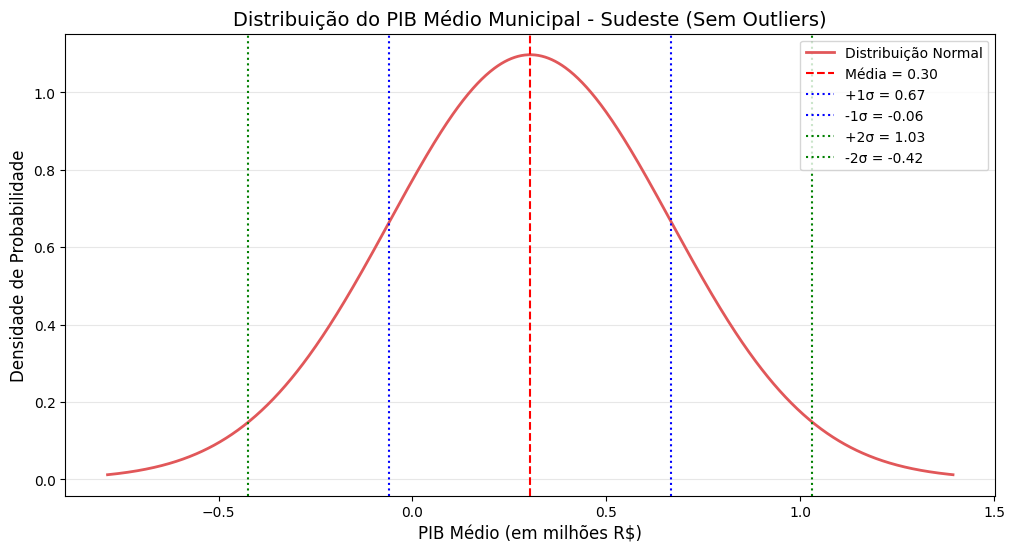

In [31]:
# Supondo que 'df_sudeste_sem_outliers' já está definido
estatisticas = df_sudeste_sem_outliers['Media_PIB'].agg(['mean', 'std', 'count'])
print(estatisticas)

# Parâmetros da distribuição
mu = estatisticas['mean']  # Média do PIB no Sudeste
sigma = estatisticas['std']  # Desvio padrão do PIB no Sudeste

# Gerar pontos para a curva normal
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = norm.pdf(x, mu, sigma)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(x, y, color='#E15759', linewidth=2, label='Distribuição Normal')  # Cor do Sudeste

# Destacar a média e desvios padrão
plt.axvline(mu, color='red', linestyle='--', label=f'Média = {mu:.2f}')
plt.axvline(mu + sigma, color='blue', linestyle=':', label=f'+1σ = {mu + sigma:.2f}')
plt.axvline(mu - sigma, color='blue', linestyle=':', label=f'-1σ = {mu - sigma:.2f}')
plt.axvline(mu + 2*sigma, color='green', linestyle=':', label=f'+2σ = {mu + 2*sigma:.2f}')
plt.axvline(mu - 2*sigma, color='green', linestyle=':', label=f'-2σ = {mu - 2*sigma:.2f}')

# Personalização
plt.title('Distribuição do PIB Médio Municipal - Sudeste (Sem Outliers)', fontsize=14)
plt.xlabel('PIB Médio (em milhões R$)', fontsize=12)
plt.ylabel('Densidade de Probabilidade', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [32]:
# Verifique se há municípios suficientes
n_amostra = min(100, len(df_sudeste_sem_outliers))

# Selecione a amostra aleatória
amostra_sudeste = df_sudeste.sample(n=n_amostra)

# Mantenha apenas as colunas desejadas, na ordem correta
amostra_sudeste = amostra_sudeste[['UF', 'Municipio', 'Regiao', 'Media_PIB']]

# Salve o CSV sem índice e com formatação padrão
amostra_sudeste.to_csv("amostra_100_municipios_sudeste.csv", 
                      index=False,
                      float_format='%.5f')  # Garante 5 casas decimais para Media_PIB

# Mostre uma prévia
print(f"Total de municípios na amostra: {len(amostra_sudeste)}")
print(amostra_sudeste.head())

Total de municípios na amostra: 100
      UF                    Municipio   Regiao  Media_PIB
1913  MG                     Piracema  Sudeste     0.1350
3554  RJ  Engenheiro Paulo de Frontin  Sudeste     0.2425
4855  SP                   Cosmópolis  Sudeste     1.5200
855   ES          São José do Calçado  Sudeste     0.1500
2056  MG       São Domingos das Dores  Sudeste     0.0675


In [33]:
# Supondo que 'df_sudeste_sem_outliers' já está definido
estatisticas_sudeste = amostra_sudeste['Media_PIB'].agg(['mean', 'std', 'count'])

erro_padrao = estatisticas['std'] / (100**(1/2))
print(f"Erro padrão: {erro_padrao:.2f}")

if ((estatisticas_sudeste['mean'] >= (estatisticas['mean'] - 2*erro_padrao)) and (estatisticas_sudeste['mean'] <= (estatisticas['mean'] + 2*erro_padrao))):
    print("A amostra é representativa")
else:
    print("A amostra não é representativa")

print(estatisticas_sudeste)

Erro padrão: 0.04
A amostra não é representativa
mean       2.021988
std        6.611324
count    100.000000
Name: Media_PIB, dtype: float64


## **Por Estado**

In [34]:
# Dicionário para as tabelas
municipios_por_uf = {}

# Pegar todas as regiões únicas
estados = dados_crise['UF'].unique()

for estado in estados:
    municipios_por_uf[estado] = dados_crise[dados_crise['UF'] == estado]

for estado in estados:
    tabela = dados_crise[dados_crise['UF'] == estado].copy()
    tabela[year_cols] = (tabela[year_cols] / 1_000_000).round(2)  # Converte para milhões e arredonda
    municipios_por_uf[estado] = tabela

municipios_por_uf['SP'].head()

,UF,Municipio,Regiao,2013,2014,2015,2016,2017,2018,2019,2020
4685,SP,Palestina,Sudeste,0.26,0.27,0.47,0.35,0.38,0.30,0.36,0.43
4686,SP,São Sebastião,Sudeste,5.41,5.26,3.41,2.61,3.38,3.78,3.50,3.42
4687,SP,Tabatinga,Sudeste,0.17,0.19,0.20,0.24,0.28,0.24,0.26,0.30
4688,SP,Jaborandi,Sudeste,0.12,0.11,0.12,0.14,0.15,0.14,0.14,0.15
4689,SP,Novo Horizonte,Sudeste,0.79,0.92,1.04,1.26,1.32,1.04,1.20,1.39


In [35]:
# Dicionário para armazenar as médias por município
medias_por_uf = {}

# Iterar sobre cada região e calcular a média do PIB para cada município
for uf, df in municipios_por_uf.items():
    # Selecionar apenas as colunas dos anos (2013-2020) e calcular a média por linha (município)
    df['Media_PIB'] = df.loc[:, '2013':'2020'].mean(axis=1)
    
    # Armazenar o DataFrame com a nova coluna de média
    medias_por_uf[uf] = df[['UF', 'Municipio', 'Regiao', 'Media_PIB']]
    # Atualizar o DataFrame em municipios_por_uf para incluir a coluna Media_PIB
    municipios_por_uf[uf] = df

df_mg = municipios_por_uf['MG']
df_mg.head()


,UF,Municipio,Regiao,2013,2014,2015,2016,2017,2018,2019,2020,Media_PIB
1326,MG,Campestre,Sudeste,0.24,0.27,0.31,0.34,0.35,0.33,0.32,0.42,0.3225
1327,MG,Ouro Branco,Sudeste,2.94,3.11,3.22,2.97,3.36,4.08,4.18,4.58,3.5550
1328,MG,Viçosa,Sudeste,1.19,1.30,1.40,1.51,1.56,1.63,1.75,1.78,1.5150
1329,MG,Candeias,Sudeste,0.19,0.21,0.23,0.31,0.26,0.25,0.25,0.30,0.2500
1330,MG,Canápolis,Sudeste,0.29,0.28,0.26,0.33,0.35,0.34,0.43,0.56,0.3550


In [36]:
def remove_outliers_iqr(df, column='Media_PIB'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.8 * IQR
    upper_bound = Q3 + 1.8 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_mg = municipios_por_uf['MG']
df_mg_sem_outliers = remove_outliers_iqr(df_mg)
df_mg_sem_outliers.head()

,UF,Municipio,Regiao,2013,2014,2015,2016,2017,2018,2019,2020,Media_PIB
1326,MG,Campestre,Sudeste,0.24,0.27,0.31,0.34,0.35,0.33,0.32,0.42,0.32250
1329,MG,Candeias,Sudeste,0.19,0.21,0.23,0.31,0.26,0.25,0.25,0.30,0.25000
1330,MG,Canápolis,Sudeste,0.29,0.28,0.26,0.33,0.35,0.34,0.43,0.56,0.35500
1331,MG,Santa Bárbara,Sudeste,0.70,0.72,0.70,0.72,0.77,0.83,0.87,1.10,0.80125
1333,MG,Boa Esperança,Sudeste,0.61,0.65,0.70,0.88,0.83,0.82,0.77,0.93,0.77375


mean       0.162675
std        0.163880
count    742.000000
Name: Media_PIB, dtype: float64


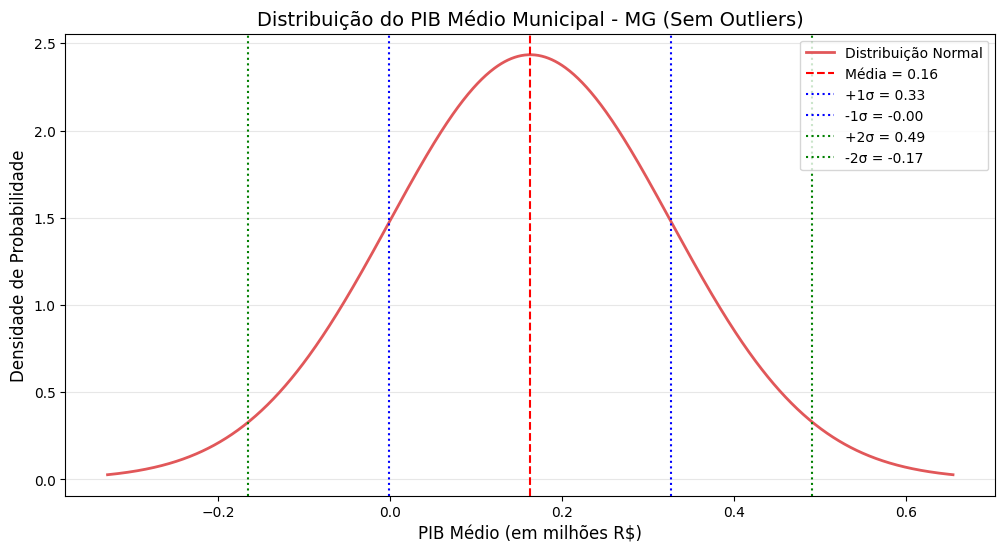

In [37]:
# Supondo que 'df_sudeste_sem_outliers' já está definido
estatisticas_mg = df_mg_sem_outliers['Media_PIB'].agg(['mean', 'std', 'count'])
print(estatisticas_mg)

# Parâmetros da distribuição
mu = estatisticas_mg['mean']  # Média do PIB no Sudeste
sigma = estatisticas_mg['std']  # Desvio padrão do PIB no Sudeste

# Gerar pontos para a curva normal
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = norm.pdf(x, mu, sigma)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(x, y, color='#E15759', linewidth=2, label='Distribuição Normal')  # Cor do Sudeste

# Destacar a média e desvios padrão
plt.axvline(mu, color='red', linestyle='--', label=f'Média = {mu:.2f}')
plt.axvline(mu + sigma, color='blue', linestyle=':', label=f'+1σ = {mu + sigma:.2f}')
plt.axvline(mu - sigma, color='blue', linestyle=':', label=f'-1σ = {mu - sigma:.2f}')
plt.axvline(mu + 2*sigma, color='green', linestyle=':', label=f'+2σ = {mu + 2*sigma:.2f}')
plt.axvline(mu - 2*sigma, color='green', linestyle=':', label=f'-2σ = {mu - 2*sigma:.2f}')

# Personalização
plt.title('Distribuição do PIB Médio Municipal - MG (Sem Outliers)', fontsize=14)
plt.xlabel('PIB Médio (em milhões R$)', fontsize=12)
plt.ylabel('Densidade de Probabilidade', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [38]:
# Selecione a amostra aleatória primeiro
amostra_mg = df_mg_sem_outliers.sample(n=n_amostra)  # Adicione random_state para reprodutibilidade

# Depois selecione apenas as colunas desejadas
amostra_mg = amostra_mg[['UF', 'Municipio', 'Regiao', 'Media_PIB']]

# Salve o CSV
amostra_mg.to_csv("amostra_municipios_mg.csv", 
                 index=False,
                 float_format='%.5f')

# Mostre uma prévia
print(f"Total de municípios na amostra: {len(amostra_mg)}")
print(amostra_mg.head())

Total de municípios na amostra: 100
      UF           Municipio   Regiao  Media_PIB
1645  MG          Guaraciaba  Sudeste    0.08125
1483  MG  Carmo do Rio Claro  Sudeste    0.43250
1736  MG            Jordânia  Sudeste    0.08125
2075  MG  São José da Safira  Sudeste    0.03875
2158  MG             Vieiras  Sudeste    0.04000


In [39]:
# Supondo que 'df_sudeste_sem_outliers' já está definido
estatisticas_mg_amostra = amostra_mg['Media_PIB'].agg(['mean', 'std', 'count'])

erro_padrao = estatisticas['std'] / (35**(1/2))
print(f"Erro padrão: {erro_padrao:.2f}")

if ((estatisticas_mg_amostra['mean'] >= (estatisticas_mg['mean'] - 2*erro_padrao)) and (estatisticas_mg_amostra['mean'] <= (estatisticas_mg['mean'] + 2*erro_padrao))):
    print("A amostra é representativa")
else:
    print("A amostra não é representativa")

print(estatisticas_mg_amostra)
print(estatisticas_mg)

Erro padrão: 0.06
A amostra é representativa
mean       0.165325
std        0.162682
count    100.000000
Name: Media_PIB, dtype: float64
mean       0.162675
std        0.163880
count    742.000000
Name: Media_PIB, dtype: float64


In [230]:
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# ◾ Lista de anos
anos = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

# ◾ 1) Cópia com log
df_log = df_mg_sem_outliers.copy()
for ano in anos:
    df_log[ano] = np.log(df_log[ano])

# ◾ 2) Discretização por ano (corrigido)
df_discretizado = df_log.copy()
for ano in anos:
    # Discretiza cada ano separadamente
    df_discretizado[ano] = pd.qcut(
        df_log[ano], 
        q=3, 
        labels=["Baixo", "Medio", "Alto"],
        duplicates='drop'
    )

# Verificação da distribuição por ano
for ano in anos:
    print(f"\nDistribuição {ano}:")
    print(df_discretizado[ano].value_counts())

# ◾ 3) Transações
transacoes = []
for _, row in df_discretizado.iterrows():
    transacoes.append([f"PIB_{ano}_{row[ano]}" for ano in anos])

# ◾ 4) One-hot encode
te = TransactionEncoder()
te_ary = te.fit(transacoes).transform(transacoes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# ◾ 5) Apriori com parâmetros ajustados
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)

# ◾ 6) Limpeza aprimorada
# Remove regras com itens repetidos e métricas inválidas
rules = rules[
    (rules['antecedents'] != rules['consequents']) &
    (rules['confidence'] < np.inf) & 
    (rules['lift'] < np.inf)
].copy()

# Funções auxiliares atualizadas
def parse_item(item):
    _, ano, faixa = str(item).strip("'frozenset({})").replace("'", "").split('_')
    return int(ano), faixa

def is_strictly_consecutive(years: list[int]) -> bool:
    if len(years) < 1:
        return False
    years_sorted = sorted(set(years))
    return (years_sorted[-1] - years_sorted[0] + 1) == len(years_sorted)

def is_valid_transition(row):
    ant = [parse_item(i) for i in row['antecedents']]
    cons = [parse_item(i) for i in row['consequents']]
    
    if not ant or not cons:
        return False
    
    anos_ant = [a for a, _ in ant]
    anos_cons = [a for a, _ in cons]
    
    # Apenas verifica se o consequente é posterior ao antecedente
    separacao_temporal = (min(anos_cons) > max(anos_ant))
    
    # Verifica mudança de faixa (pelo menos uma categoria diferente)
    faixas_ant = {f for _, f in ant}
    faixas_cons = {f for _, f in cons}
    faixa_check = not faixas_ant.issubset(faixas_cons)
    
    return separacao_temporal and faixa_check

# Aplica filtro
rules_transicoes_stritas = rules[rules.apply(is_valid_transition, axis=1)]

# Ordena e exporta
resultado_final = (
    rules_transicoes_stritas
    [['antecedents', 'consequents', 'support', 'confidence', 'lift']]
    .sort_values(by=['support', 'confidence'], ascending=False)
)

resultado_final.to_csv('regras_transicoes_stritas_corrigido.csv', index=False)
print("\nRegras finais:")
print(resultado_final.head(10))


Distribuição 2013:
2013
Baixo    297
Alto     238
Medio    207
Name: count, dtype: int64

Distribuição 2014:
2014
Baixo    263
Alto     240
Medio    239
Name: count, dtype: int64

Distribuição 2015:
2015
Medio    253
Baixo    252
Alto     237
Name: count, dtype: int64

Distribuição 2016:
2016
Baixo    267
Alto     238
Medio    237
Name: count, dtype: int64

Distribuição 2017:
2017
Baixo    262
Alto     242
Medio    238
Name: count, dtype: int64

Distribuição 2018:
2018
Baixo    258
Medio    247
Alto     237
Name: count, dtype: int64

Distribuição 2019:
2019
Baixo    286
Alto     238
Medio    218
Name: count, dtype: int64

Distribuição 2020:
2020
Baixo    280
Alto     243
Medio    219
Name: count, dtype: int64

Regras finais:
                                           antecedents                       consequents   support  confidence      lift
547                   (PIB_2017_Medio, PIB_2013_Baixo)                  (PIB_2018_Medio)  0.049865    0.860465  2.584879
473                   